# PROJECT DEMONSTRATION NOTEBOOK

## I. Introduction

Yelp is a business listing directory service and user experience or review sharing website with social networking features. It allows users to provide ratings to businesses and write reviews based on their experience. The users can share experiences through reviews and tips. The user review has long textual content that details the user’s experience. It usually has a length of up to roughly 2000 characters. Whereas a user tip is a short comment consisting of few lines of a length of about one hundred words. Depending on the type of experience a user had, the review can be broadly classified as helpful or not helpful to that business. 

Some reviews describe the dimensions of a business and the experience of user with respect to those dimensions. These are the reviews
we want to lay our focus on, in understanding what how these dimensions can be useful to other users who want to try a service of that business.

The ratings given by users can be based on multiple aspects of a business. A rating of 3 tells ius the overall experience of the user, but it does not throw any light on the reasoning behind it and what components of business were considered whilst rating. The textual review always contains more information. 

For example, there could be a restaurant review that says - 

“I had a really good time, but the waiter was rude. Good food bad service!”. 

Here different sentiments are being expressed towards the food and the service components at
the restaurant.

### Goal

Our goal is to try and classify these textual reviews with tags to know which business components they address
and do a sentiment analysis at the tag level to see which component is going well for the business. We also
wish to do an overall sentiment analysis of each review. We are hoping that comparing the overall sentiment
along with the tag level sentiment can help us understand which business component the key player in the
overall user satisfaction is.

In [108]:
import pandas as pd
import nltk
import re
import calendar
from pandas import DataFrame as df
from datetime import date
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import operator
import json
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
%pylab inline
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import string
import gensim
from gensim import corpora
from nltk.stem.wordnet import WordNetLemmatizer
import pyLDAvis.gensim as pylda
import pyLDAvis as pyl
from gensim import models as md
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import gmaps
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


## II. Data Load

We imported 5 files that we deemed necessary for our analysis i.e. User, Tip, Business, Checkin and Review. We downloaded all of the data from the yelp dataset challenge website [https://www.yelp.com/dataset/challenge]. 

###### a. User

This file has the detailed data on users, their identification information and other attributes. 

In [51]:
user = pd.read_json('user.json', lines = True)

In [52]:
print(user.shape)

(1326101, 22)


###### b. Tip

This is another important file for our analysis, because we plan to concatenate the review file with this one to
generate a combined categorization for tagging the reviews. The merge for these two files will be based on the
“business_id” and “user_id” column.


In [54]:
tip = pd.read_json('tip.json', lines = True)

In [55]:
print(tip.shape)

(1098325, 5)


###### c. Business

This data file is a detail list about businesses and their information. The “attributes column of this data file
shows what kind of added services is the business providing. This column was unclean since there were many
joined attributes, and they will require separation.


In [56]:
business = pd.read_json('business.json', lines = True)

In [57]:
print(business.shape)

(174567, 15)


###### d. Check in

This file gives information on the check-in hours of the business. From here we can also find out the most
popular hours of opening from here and conduct an analysis to find out how many customers visit during these
peak hours and if there are any trends.

In [58]:
check_in = pd.read_json('checkin.json', lines = True)

In [59]:
print(check_in.shape)

(146350, 2)


###### e. Review

This is one of the important files for our analysis because it provides the reviews from users and captures the
sentiments of their experiences. Columns “useful”, “funny” and “cool”, were tags that were provided within
the data set to classify the review into one of these categories. We are also hoping to see if we can extract key
features that make a comment useful, funny or cool.

In [ ]:
with open('review.json') as json_file:      
    data = json_file.readlines() 
    data = list(map(json.loads, data)) 
reviews = df(data)

###### Below is a list of sample data from each of the files.


In [60]:
user.head(1)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.67,0,0,0,0,0,0,0,0,1,...,0,[],0,"[cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...",0,Johnny,8,0,oMy_rEb0UBEmMlu-zcxnoQ,2014-11-03


In [61]:
tip.head(1)

,business_id,date,likes,text,user_id
0,tJRDll5yqpZwehenzE2cSg,2012-07-15,0,Get here early enough to have dinner.,zcTZk7OG8ovAmh_fenH21g


In [62]:
business.head(1)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.33069,-111.978599,Dental by Design,,85044,22,4.0,AZ


In [63]:
check_in.head(1)

,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1..."


## III. Data Processing & Analysis

### A. Business Overview

##### 1. Concentraion of Businesses across States

In [64]:
business_counts = business[['state', 'business_id']].groupby(['state'])['business_id'].agg('count').sort_values(ascending=False)

In [65]:
top_business_counts=business_counts.head(6)
top_state= top_business_counts.index.tolist()
top_state

['AZ', 'NV', 'ON', 'NC', 'OH', 'PA']

In [66]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

list_new=[]
for state,state_abbrev in us_state_abbrev.items():
    for state_val in top_state:
        if state_val == state_abbrev:
            list_new.append(state)
list_new

['Arizona', 'Nevada', 'North Carolina', 'Ohio', 'Pennsylvania']

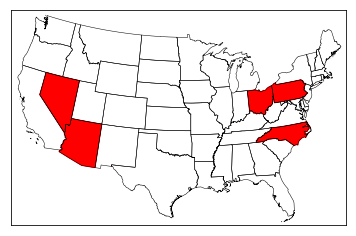

In [67]:
# create a map of USA
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load pre-defined shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can look up the shape obect for a state by it's name
state_names = []
for shape_dict in map.states_info:
    state_names.append(shape_dict['NAME'])

ax = plt.gca() # get current axes instance

# Draw the filled polygon
for state in list_new:
    seg = map.states[state_names.index(state)]
    poly = Polygon(seg, facecolor='red',edgecolor='red')
    ax.add_patch(poly)


plt.show()

Popular cities of Arizona with maximum number of businesses in the dataset.

In [68]:
business[business['state'] == 'AZ'].groupby(['city'])['business_id'].agg('count').sort_values(ascending=False).head()

city
Phoenix       17213
Scottsdale     8227
Mesa           5759
Tempe          4263
Chandler       3993
Name: business_id, dtype: int64

##### 2. Distribution of star ratings

For Businesses, we specifically wanted to see the distribution of stars that they get.

From the graph below it is clear that, most of the businesses got a rating of either 3 or above.

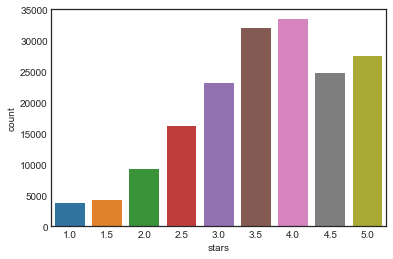

In [69]:
plt.style.use('seaborn-white')
sns.countplot(x='stars',data=business);

To visualize the distribution of number of reviews that a business has, we applied log since the distribution is extremely skewed.

/Users/ambika/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


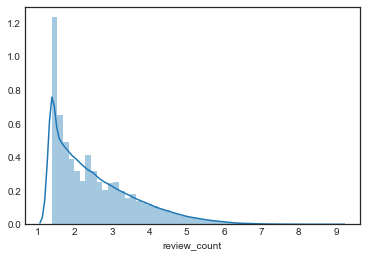

In [70]:
sns.distplot(business['review_count'].apply(np.log1p))

##### 3. Wordcloud of most popular business names

The top words used in business names in our dataset have been visualized with a word cloud.

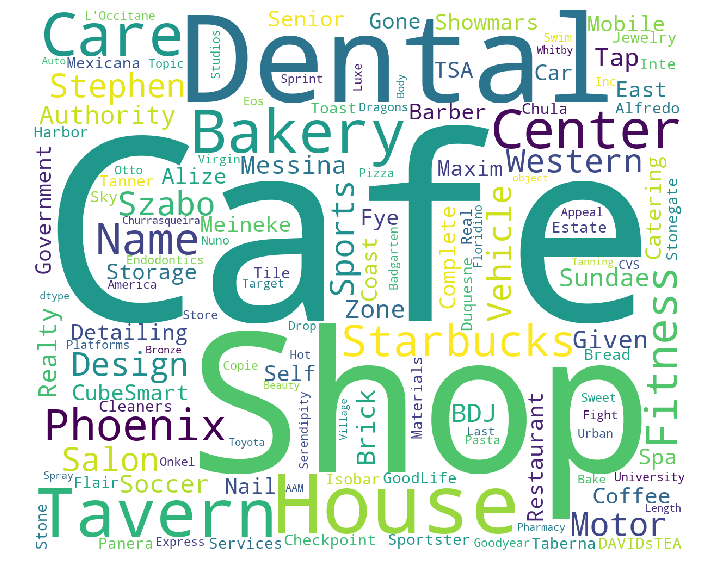

In [71]:
plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='white',
                          width=1200,
                      stopwords = STOPWORDS,
                          height=1000
                         ).generate(str(business['name']))


plt.imshow(wordcloud)
plt.axis('off');

### B. Tips Overview

##### 1.1 Cleaning of tip text

In [72]:
tip['text'] = tip['text'].str.lower()
tip['text'] = tip['text'].str.replace(".", "")
tip['text'] = tip['text'].str.replace(",", "")
tip['text'] = tip['text'].str.replace(";", "")
tip['text'] = tip['text'].str.replace("!", "")
tip['text'] = tip['text'].str.replace("?", "")
tip['text'] = tip['text'].str.replace(")", "")
tip['text'] = tip['text'].str.replace("(", "")
tip['text'] = tip['text'].str.replace("-", "")
tip['text'] = tip['text'].str.replace("#", "")
tip['text'] = tip['text'].str.replace(":", "")
tip['text'] = tip['text'].str.replace("'", "")
tip['text'] = tip['text'].str.replace("$", "")
tip['text'] = tip['text'].str.replace("*", "")
tip['text'] = tip['text'].str.replace("*", "")
tip['text'] = tip['text'].str.replace("@", "")
tip['text'] = tip['text'].str.replace("&", "")
tip['text'] = tip['text'].str.replace('"', "")
tip['text'] = tip['text'].str.replace('[', "")
tip['text'] = tip['text'].str.replace(']', "")
tip['text'] = tip['text'].str.replace('\d+', '')

In [73]:
RE = re.compile(u'[⺀-⺙⺛-⻳⼀-⿕々〇〡-〩〸-〺〻㐀-䶵一-鿃豈-鶴侮-頻並-龎]', re.UNICODE)

In [74]:
stop_words = set(stopwords.words('english'))

In [120]:
tokenizer = RegexpTokenizer(r'\w+')

#### 1.2 Filtering Businesses for Restaurant Data

In [75]:
food_synset = wn.synset('food.n.02')
food = list(set([w for s in food_synset.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
food.append("Restaurant")
food.append("Bars")
food.append("Nightlife")

In [76]:
restaurant_tips = tip[tip['text'].str.contains('|'.join(food))]

In [77]:
len(restaurant_tips)

369098

In [78]:
restaurant_tips.groupby(['business_id'])['text'].count().sort_values(ascending=False).head()

business_id
FaHADZARwnY4yvlvpnsfGA    1054
eoHdUeQDNgQ6WYEnP2aiRw     564
4JNXUYY8wbaaDmk3BPzlWw     533
DkYS3arLOhA8si5uUEmHOw     494
RESDUcs7fIiihp38-d6_6g     453
Name: text, dtype: int64

##### 2. Selecting one restaurant for detailed analysis

After filtering data from tip on only restaurants, we wanted to perform a detailed analysis of a single restaurant, and try to see sentiment scores and identify top words that contribute to that score.

In [79]:
business[business['business_id'] == 'eoHdUeQDNgQ6WYEnP2aiRw']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
21006,"Caesars Palace Las Vegas Hotel And Casino, 357...","{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",eoHdUeQDNgQ6WYEnP2aiRw,"[Social Clubs, Arts & Entertainment, American ...",Las Vegas,"{'Monday': '9:00-22:00', 'Tuesday': '9:00-22:0...",0,36.11567,-115.173317,Serendipity 3,The Strip,89109,3910,3.0,NV


##### 3. Sentiment Analysis of tips for Serendipity (selected business)

Our objective for sentiment analysis has been to label tip text columns into positve, negative, neutral sentiments through the nltk package's sentiment analyzer. We manually verified a lot of cases that fell under each sentiment, and can conclude that the sentiment analyzer did a very good prediction of positve and negative sentiment scores. But we also felt that it was relying quite a bit on the neutral score in order to predict the sentiment score of the text which seemed to be not very positive or very negative. 

In [80]:
sia = SentimentIntensityAnalyzer()

In [81]:
serendipity_tips = pd.DataFrame(restaurant_tips[restaurant_tips['business_id']== 'eoHdUeQDNgQ6WYEnP2aiRw']['text'])
serendipity_tips = serendipity_tips.reset_index()


In [82]:
sentiment_scores = []
for line in serendipity_tips['text']:
    sentiment_scores.append(sia.polarity_scores(line))


In [83]:
sentiment_scores= pd.DataFrame(sentiment_scores)
sentiment_scores.head()

,compound,neg,neu,pos
0,0.8689,0.000,0.795,0.205
1,0.1531,0.179,0.612,0.209
2,0.5023,0.000,0.764,0.236
3,0.2960,0.000,0.855,0.145
4,0.0000,0.000,1.000,0.000


Merging tip text to get text column detail for predicted scores.

In [84]:
score_merge =pd.merge(serendipity_tips,sentiment_scores,left_index=True,right_index=True)

In [85]:
score_merge = score_merge.drop('index',axis=1)

In [86]:
score_merge.head()

,text,compound,neg,neu,pos
0,if you have a sweet tooth or a mouth full of s...,0.8689,0.000,0.795,0.205
1,great veggie burger nd trip horrible service l...,0.1531,0.179,0.612,0.209
2,the frozen hot chocolate was good and i liked ...,0.5023,0.000,0.764,0.236
3,eerr yeah over hyped frozen hot chocolate worl...,0.2960,0.000,0.855,0.145
4,frozen hot chocolateyummy,0.0000,0.000,1.000,0.000


##### 4. Classifying tips into positive, negative and neutral sentiment based on the sentiment scores

In [87]:
pos_scores = list(score_merge[score_merge['pos'] >= 0.5]['text'])
neg_scores = list(score_merge[score_merge['neg'] >= 0.2]['text'])
neu_scores = list(score_merge[score_merge['neu'] >= 0.9]['text'])

In [88]:
def get_words(word_list):
    new_list =[]
    for line in word_list:
        for word in line.split():
            if word not in stop_words:
                new_list.append(word)
    return Counter(new_list)
            
pos_word_list =  get_words(pos_scores)
neu_word_list = get_words(neu_scores)
neg_word_list = get_words(neg_scores)

##### 5. Plot of high frequency words for each sentiment category

These lists give us the words that fell into each of the three scoring categories. Below is the frequency distribution plot for the same.

In [89]:
def plot_hist(word_list,arg):
    
    plt.figure(figsize=(6, 6))
    if arg==1:
        df = pd.DataFrame(word_list.most_common(5),columns=['word','frequency'])
        df.plot(kind='barh',x='word',color='green')
    elif arg==2:
    
        df = pd.DataFrame(word_list.most_common(15),columns=['word','frequency'])
        df = df[~df['word'].isin(['frozen','hot','chocolate'])]
        df.plot(kind='barh',x='word',color='red')
    else:
        df = pd.DataFrame(word_list.most_common(5),columns=['word','frequency'])
        df.plot(kind='barh',x='word',color='orange')

<Figure size 432x432 with 0 Axes>

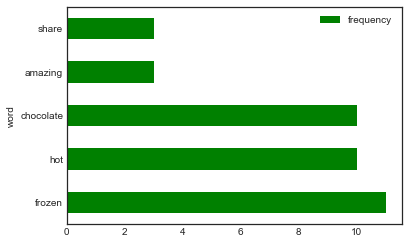

In [90]:
plot_hist(pos_word_list,1)

<Figure size 432x432 with 0 Axes>

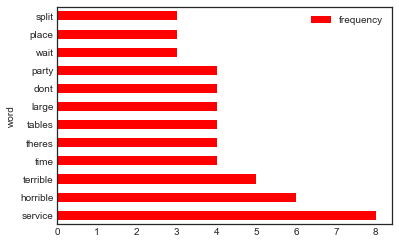

In [91]:
plot_hist(neg_word_list,2)

<Figure size 432x432 with 0 Axes>

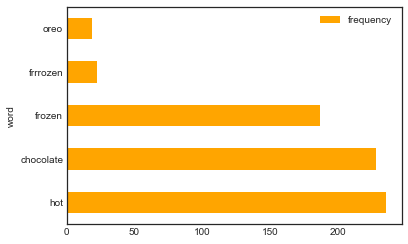

In [92]:
plot_hist(neu_word_list,3)

### Interpretation

##### Positives :  Hot, Chocolate and frozen were the most frequently used words in tips that had a positive or neutral sentiment. These seem to be the things that are going well for serendipity. Serendipity should focus on desserts and beverages and maintain their quality in this particular food category since this is the category that has been attracting a positive sentiment from customers.

##### Negatives : The number of negative reviews are too low compared to the number of positive reviews. There are a lot of neutral reviews. The words terrible and service seem to be the most frequently used words in the tips that had a negative sentiment or a negative score above 0.2. Serendipity needs to focus on improving their service.

## IV. Topic Modeling using LDA

This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

We started by choosing 50 topics to initialize this model. Computationally, it was taking quite some time, but we wanted to ensure we captured all features.

Later, we used a model with 10 topics to visualise and see what words were contributing maximum to those topics.

In [93]:
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [94]:
def clean(tip_text):
    stop_free = " ".join([i for i in str(tip_text).lower().split() if i not in stop_words])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

tip_clean = [clean(tip_text).split() for tip_text in restaurant_tips['text'].head(10000)]        

In [95]:
dictionary = corpora.Dictionary(tip_clean)

doc_term_matrix = [dictionary.doc2bow(tip) for tip in tip_clean]

In [96]:
Lda = gensim.models.ldamodel.LdaModel

In [97]:
ldamodel = Lda(doc_term_matrix, num_topics=50, id2word = dictionary, passes=50)

In [98]:
print(ldamodel.print_topics(num_topics=10, num_words=4))

[(42, '0.261*"great" + 0.090*"food" + 0.078*"service" + 0.060*"awesome"'), (7, '0.074*"cream" + 0.065*"tea" + 0.062*"ice" + 0.058*"green"'), (9, '0.077*"need" + 0.046*"dont" + 0.041*"give" + 0.037*"house"'), (5, '0.142*"sandwich" + 0.115*"fish" + 0.061*"check" + 0.031*"bagel"'), (35, '0.102*"always" + 0.083*"fresh" + 0.048*"pretty" + 0.033*"worth"'), (46, '0.053*"breakfast" + 0.037*"minute" + 0.028*"pm" + 0.021*"last"'), (11, '0.170*"go" + 0.057*"eat" + 0.044*"rib" + 0.031*"every"'), (37, '0.184*"cheese" + 0.058*"bacon" + 0.039*"grilled" + 0.039*"wing"'), (12, '0.132*"salad" + 0.086*"side" + 0.033*"table" + 0.033*"loved"'), (14, '0.117*"make" + 0.062*"sure" + 0.058*"first" + 0.041*"time"')]


#### 2. Visualisation of LDA using pyLDAvis

"pyLDAvis" was one package that enabled efficient visualization of how important the words were for a particular topic.

The interactive visualization below enables a user to view the prevalence of each topic from the size of the circles, as well as the frequency distribution of the tokenized words from the model.

For example topic 21 consists of terms like roll, donut, cold, flavor and curry in maximum frequency. This topic is clearly about food.

By adjusting the importance slider, we can set lambda to adjust relevance.

In [99]:
pyl.enable_notebook()

In [100]:
visualisation = pylda.prepare(ldamodel, doc_term_matrix, dictionary)

In [101]:
visualisation

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
42     3.814594        1       1 -0.278701  0.112161
31     3.007705        1       2 -0.034578  0.008715
11     2.694350        1       3  0.010301 -0.033561
34     2.572049        1       4 -0.155645  0.102915
46     2.514102        1       5  0.005136  0.101310
18     2.346227        1       6  0.125252 -0.038898
30     2.344723        1       7 -0.024800 -0.103501
38     2.309195        1       8 -0.020057 -0.128003
33     2.285310        1       9 -0.078871 -0.070207
35     2.283758        1      10 -0.134722 -0.026149
36     2.225139        1      11  0.007712 -0.085913
28     2.202025        1      12  0.035675  0.062708
41     2.191072        1      13 -0.087869  0.121290
9      2.124354        1      14  0.111546  0.018211
20     2.101683        1      15  0.021638 -0.049395
14     2.089673        1      16  0.105608  0.010717
5      2.074607        1      17  0.020166 -0.017774
37     2.071663        1      18  0.007466 -0.110965
3      2.067298        1      19 -0.144815 -0.034088
7      2.064454        1      20  0.005937 -0.031163
6      2.043411        1      21 -0.073193 -0.126906
29     1.979929        1      22 -0.068392 -0.027627
12     1.966654        1      23 -0.004495 -0.079526
32     1.953482        1      24 -0.038968 -0.111860
39     1.944898        1      25 -0.041914  0.063549
13     1.924486        1      26  0.096262  0.054297
22     1.916268        1      27 -0.100818  0.070500
1      1.878787        1      28  0.008044  0.148393
26     1.851525        1      29  0.069210  0.061996
25     1.816106        1      30 -0.060679 -0.152492
48     1.806507        1      31 -0.010601  0.021498
44     1.780316        1      32  0.099434  0.061958
4      1.779403        1      33 -0.019563 -0.111907
49     1.761672        1      34  0.097235  0.099890
19     1.733305        1      35 -0.101800  0.063694
47     1.723272        1      36  0.086997 -0.044293
23     1.717972        1      37  0.108749  0.058958
21     1.715616        1      38  0.040345  0.110740
40     1.703960        1      39  0.014335 -0.010780
16     1.698636        1      40 -0.031796  0.044700
45     1.696331        1      41  0.005672  0.005056
27     1.688388        1      42  0.053828  0.002590
43     1.668526        1      43  0.042798 -0.062186
8      1.660267        1      44  0.026663  0.055025
10     1.629699        1      45  0.046139  0.013296
15     1.610639        1      46  0.091996 -0.004515
2      1.578426        1      47  0.055360 -0.050101
17     1.559057        1      48  0.032410  0.031213
0      1.484916        1      49  0.033816 -0.071343
24     1.343567        1      50  0.046549  0.077773, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
3     Default  872.000000        great  872.000000  30.0000  30.0000
9     Default  577.000000         best  577.000000  29.0000  29.0000
435   Default  428.000000         love  428.000000  28.0000  28.0000
177   Default  408.000000          try  408.000000  27.0000  27.0000
121   Default  400.000000           go  400.000000  26.0000  26.0000
775   Default  333.000000       cheese  333.000000  25.0000  25.0000
206   Default  322.000000    delicious  322.000000  24.0000  24.0000
100   Default  288.000000      amazing  288.000000  23.0000  23.0000
110   Default  566.000000         food  566.000000  22.0000  22.0000
36    Default  257.000000     sandwich  257.000000  21.0000  21.0000
82    Default  241.000000         taco  241.000000  20.0000  20.0000
475   Default  255.000000          fry  255.000000  19.0000  19.0000
627   Default  237.000000         game  237.000000  18.0000  18.0000
19    Default  228.000000        salad  228.000000  17.0000  17.0000
629   Default  222.000000       burger  222.000000  16.0000  16.0000
562   Default  220.000000   

#### Interpretation:
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

In [102]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = md.CoherenceModel(model=ldamodel, texts=tip_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.738542736406355

Coherence Score:  0.4261797678294452


A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
Low perplexity implies a good model, although coherence is a better judge of the model. Our coherence is 0.426 which tells us that our model deos a fairly decent job at clustering words into 50 topics.

## V. User Data Analysis

##### 1. Getting user info on  top 100 users who had the funny, useful and cool tags

In [103]:
top_funny = user[user['funny'] != 0].sort_values(by = 'funny', ascending = False).head(100)

In [109]:
top_useful = user[user['useful'] != 0].sort_values(by = 'useful', ascending = False).head(100)

In [110]:
top_cool = user[user['cool'] != 0].sort_values(by = 'cool', ascending = False).head(100)

##### 2. Joining the top funny,useful and cool user data with tip data based on the user_id key

In [111]:
funny_user = top_funny.join(tip.set_index('user_id'), on = 'user_id').head(100)

In [112]:
useful_user = top_useful.join(tip.set_index('user_id'), on = 'user_id').head(100)

In [113]:
cool_user = top_cool.join(tip.set_index('user_id'), on = 'user_id').head(100)

##### 3. Filtering out na values from data

In [114]:
funny_user = funny_user.dropna()
useful_user = useful_user.dropna()
cool_user = cool_user.dropna()

##### 4. Correlation

From the correlation matrix below, we can see that there is a high correlation between a review/tip being marked as funny and useful. 

A review being tagged as funny is highly likely to be tagged as useful.

In [115]:
data = user[['review_count','useful','funny']]

In [116]:
data.corr(method = 'pearson')

,review_count,useful,funny
review_count,1.000000,0.291062,0.229759
useful,0.291062,1.000000,0.845041
funny,0.229759,0.845041,1.000000


##### 5. Top words used in tips of the users whose tips were tagged "useful" "funny" or "cool"

In [117]:
funny_words = {}
cool_words = {}
useful_words = {}

In [121]:
def get_words(tag):
    user_type = {}
    for line in tag['text']:
        for word in tokenizer.tokenize(line):
            if word not in stop_words:
                if word in user_type.keys(): 
                    user_type[word] += 1
                else:
                    user_type[word] = 1
    return user_type

funny_words= get_words(funny_user)
cool_words= get_words(cool_user)
useful_words= get_words(useful_user)

In [122]:
df(sorted(funny_words.items(), key=operator.itemgetter(1),reverse=True)).head()

,0,1
0,ask,12
1,recommend,10
2,love,9
3,staff,9
4,highly,9


In [123]:
df(sorted(useful_words.items(), key=operator.itemgetter(1),reverse=True)).head()

,0,1
0,good,7
1,even,7
2,place,6
3,get,6
4,hotel,6


In [124]:
df(sorted(cool_words.items(), key=operator.itemgetter(1),reverse=True)).head()

,0,1
0,ask,8
1,good,7
2,place,6
3,hotel,6
4,dont,6


##### We are looking forward to completing the following tasks before submitting our final project report on 17th:

1.	Extend performed sentiment analysis to review file’s text column and identify top words in each category of sentiments for a business and make recommendations to them based on findings
2.	Tune LDA further to improve coherence score and make meaningful sub-topics from these 50 sub-topics.
3.	Vectorization and optimization of code was completed during this project demonstration showcase, but we still must optimize a few lines of code. Our final notebook will capture all these changes.
4.	Storyboarding for final deliverable to capture step by step analysis details and process.